## Predict price at next period with simply deep FeedForward NN as a regression
#### we can also do is as a classification, for example look for an extrean events like if tomorrow is >20% grow etc


# TODO: 
### - predict return (close price — open price)
### - price will go up [1; 0] or down [0; 1]
### - add dropout
### - Use CNN and RNN
### - add volume as a frature + sma+rsi+ichi elementary events
#### -  MACD, Ichimocku cloud, RSI, volatility and others. All these values will form multivariate time series

volatility1 = pd.DataFrame(closep).rolling(ROLLING).std().values#.tolist()

volatility2 = pd.DataFrame(closep).rolling(ROLLING).var().values#.tolist()

volatility = volatility1 / volatility2

volatility = [v[0] for v in volatility]


In [64]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY

import mysql.connector
from mysql.connector import errorcode

import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

from sklearn.metrics import r2_score
from sklearn import metrics


tf.__version__

# https://mapr.com/blog/deep-learning-tensorflow/


'1.5.0'

## connect to DB

In [2]:
DATABASE = 'prodcopy'

if DATABASE == 'prod':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'intelligenttrading-aurora-production-primary-cluster.cluster-caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '3306',
      'database': 'intelligenttrading_primary',
      'raise_on_warnings': True,
    }
    try:
      db_connection = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)
        
elif DATABASE == 'stage':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'intelligenttrading-aurora-production-postgres-cluster.cluster-caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '5432',
      'dbname': 'primary_postgres'
    }

    try:
      db_connection = pg.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)
        
elif DATABASE == 'prodcopy':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'prodclone.caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '3306',
      'database': 'intelligenttrading_primary',
      'raise_on_warnings': True,
    }

    try:
      db_connection = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)

## Get timeseries from Staging DB (both minute and hours)


In [3]:
transaction_coin = 'ETH'
counter_coin = 0

resample_period = 60

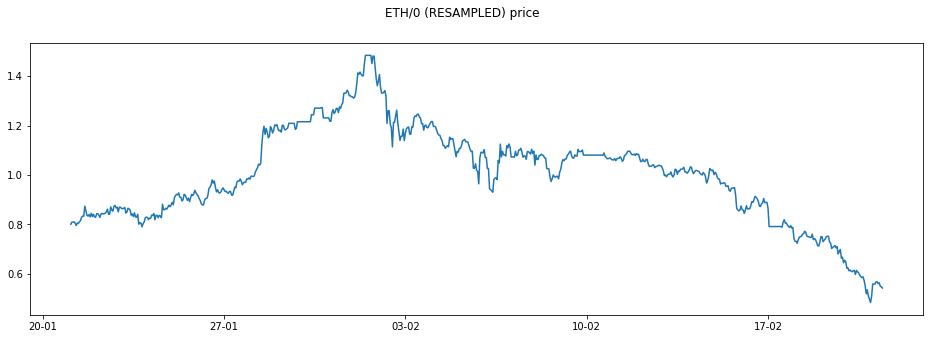

In [329]:


query = (" SELECT * FROM indicator_priceresampl WHERE \
transaction_currency='%s' AND \
counter_currency=%d \
and resample_period=%d " ) % (transaction_coin, counter_coin, resample_period)

resampl_df = pd.read_sql(query, con=db_connection)
resampl_df['timestamp'] = pd.to_datetime(resampl_df['timestamp'], unit='s')
resampl_df.index = pd.DatetimeIndex(resampl_df.timestamp)
resampl_df.sort_index(inplace=True)

# correct bad resampling
str(int(resample_period/60)) + 'H'
rule = str(int(resample_period/60)) + 'H'
res_df = resampl_df[['high_price','low_price','open_price','close_price']].resample(rule=rule).mean().bfill()

# extract closing price
ts = res_df[['open_price','close_price','high_price']]

# normalize
resampl_ts = 1+(ts - ts.mean()) / (ts.max() - ts.min())
#X = (X - np.mean(X)) / np.std(X)
resampl_ts["price"] = resampl_ts["close_price"]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
fig.suptitle("%s/%d (RESAMPLED) price" % (transaction_coin, counter_coin))
ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))
ax1.plot(resampl_ts['price'])
plt.show()


In [4]:
query = "SELECT * FROM indicator_price WHERE transaction_currency='%s' AND counter_currency=%d "
query = query % (transaction_coin, counter_coin)
df_sql = pd.read_sql(query, con=db_connection)
df_sql['timestamp'] = pd.to_datetime(df_sql['timestamp'], unit='s')
df_sql.index = pd.DatetimeIndex(df_sql.timestamp)

raw_price_ts = df_sql["price"].to_frame()



In [5]:
price_ts = raw_price_ts  # remove gaps
price_ts[pd.isnull(price_ts["price"])] = None

# resample (for smoothing) and normalize (for learning)
price_ts = price_ts.resample(rule='15min').mean()

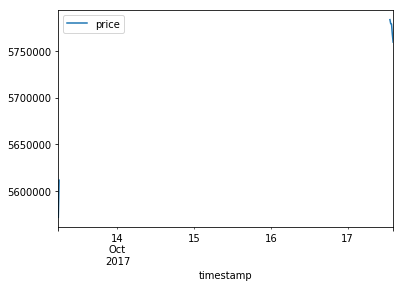

In [6]:
cutoff=420
price_ts.head(cutoff).plot()

In [7]:


# cut empty ts from the beginning
price_ts = price_ts.tail(len(price_ts)-cutoff)
price_ts = price_ts.interpolate() 

price_ts =  ((price_ts - price_ts.mean()) / (price_ts.max() - price_ts.min()) )
price_ts = price_ts + abs(price_ts.min(axis=0))



In [8]:
price_ts.min(axis=0)

price    0.0
dtype: float64

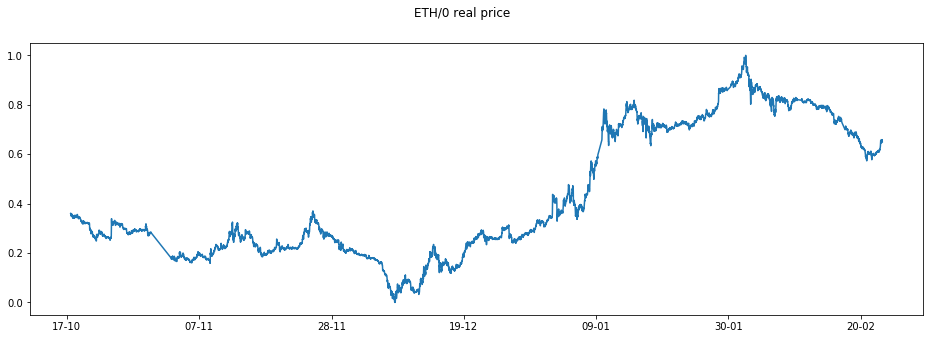

In [9]:


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
fig.suptitle("%s/%d real price" % (transaction_coin, counter_coin))
ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))
ax1.plot(price_ts)
plt.show()


In [10]:
#print(resampl_ts.shape)
print(price_ts.shape)

(12366, 1)


## Helper functions to convert ts into dataset

In [11]:


-
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) /  predictions.shape[0])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 


# CLASSIFICATION

In [44]:
# choose resample vs price
data_ts = price_ts   # or price_ts  or resampl_ts

train_num = int(len(data_ts) * 0.8)
test_num = len(data_ts) - train_num
             
ts_train = data_ts.head(train_num)
ts_test = data_ts.tail(test_num)

# convert linear ts to number of training examples
win_size = 128 #1 day
forward_time_points= 16
delta = 0.02

X_train, Y_train = classification_dataset_from_ts(data_df=ts_train, win_size=win_size, stride=1, forward_time_points=forward_time_points, delta=delta)
X_test, Y_test = classification_dataset_from_ts(data_df=ts_test, win_size=win_size, stride=1, forward_time_points=forward_time_points, delta=delta)

n_features = X_train.shape[0]
classes = Y_train.shape[0]
m_test = X_test.shape[1]
m_train = X_train.shape[1]



/Users/alex/anaconda3/anaconda/envs/py3.5.ITT/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [45]:
# cast to a datatype nessesary for tensor flow
# in tensorflow <batch size> always comes first!
#   X = tf.placeholder("float", shape=[None, x_size])
#   y = tf.placeholder("float", shape=[None, y_size])

X_train = X_train.astype(dtype=np.float32).T
Y_train = Y_train.T
X_test = X_test.astype(dtype=np.float32).T
Y_test = Y_test.T

print(X_train.shape)
print(Y_train.shape)
print("Y train same = " + str(sum(Y_train[:,0]==1)))
print("Y train above = " + str(sum(Y_train[:,1]==1)))
print("Y train below = " + str(sum(Y_train[:,2]==1)))

print(X_test.shape)
print(Y_test.shape)

print(" m_train %d, m_test %d, n_features %d, classes %d" % (m_train, m_test,n_features,classes ))
    


(9764, 128)
(9764, 3)
Y train same = 6177
Y train above = 1876
Y train below = 1711
(2346, 128)
(2346, 3)
 m_train 9764, m_test 2346, n_features 128, classes 3


In [46]:
# NOTE
# in tensorflow <batch size> always comes first!
#   X = tf.placeholder("float", shape=[None, x_size])
#   y = tf.placeholder("float", shape=[None, y_size])

batch_size = m_train-1  # make it regular batch GD (not mini-batch GD!)
layer_dims = [n_features, 100, 200, 30, 3]

graph_c = tf.Graph()
with graph_c.as_default():

    def initialize_parameters_deep(layer_dims):
        """
        parameters = initialize_parameters_deep([5,4,3])
        Arguments:
        layer_dims -- python array (list) containing the dimensions of each layer in our network

        Returns:
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                        Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                        bl -- bias vector of shape (layer_dims[l], 1)
        """

        np.random.seed(1)
        parameters = {}
        L = len(layer_dims)  # number of layers in the network

        for l in range(1, L):
            
            #parameters['W' + str(l)] = tf.Variable(tf.truncated_normal([ layer_dims[l-1], layer_dims[l] ])) * 0.01
            parameters['W' + str(l)] = tf.get_variable(
                'W' + str(l), shape=[layer_dims[l-1], layer_dims[l]],
                initializer=tf.contrib.layers.xavier_initializer()
            )
            parameters['b' + str(l)] = tf.Variable(tf.zeros( [1, layer_dims[l]] )) 
            
            # W matrix [prev_output, current hudden]
            assert ((parameters['W' + str(l)]).shape == (layer_dims[l - 1], layer_dims[l]))
            assert ((parameters['b' + str(l)]).shape == (1, layer_dims[l]))

        return parameters

    def nn_model(X, parameters):
        global glob_W3
        L = len(layer_dims)
        A = X

        for l in range(1, L-1):
            #print("Layer = " + str(l))
            A_prev = A
            #print("input A = " + str(A))
            W = parameters['W' + str(l)]
            b = parameters['b' + str(l)]
            #print(W)
            #print(A_prev)
            #print(b)
            A = tf.matmul(A_prev, W) + b
            A = tf.nn.relu(A)
            
            #glob_W1 = str(A.get_shape().as_list())


        # add Sigmoid to the last layer
        l += 1
        print("last layer:" + str(l))
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        out_layer = tf.matmul(A, W) + b
        #out_layer = tf.sigmoid(out_layer)
        glob_W3 = str(W)
        #print(W.eval())
        #print("OUTPUT=" + str(out_layer))

        return out_layer

    def regularization_term(alpha, par):
        #term = alpha * (tf.nn.l2_loss(nn_weights['h1']) + tf.nn.l2_loss(nn_biases['b1'])) + \
        #    alpha * (tf.nn.l2_loss(nn_weights['out']) + tf.nn.l2_loss(nn_biases['out']))
        #return term
        return 0

    ############  MODEL DEFINITION  ##################################
    # define tensors (matrix)
    tf_train_X = tf.placeholder(tf.float32, shape=(batch_size, n_features ))
    tf_train_y = tf.placeholder(tf.float32, shape=(batch_size, classes))
    #tf_valid_dataset = tf.constant(valid_dataset)
    #tf_test_dataset = tf.constant(X_test)

    tf_predict_X = tf.placeholder(tf.float32, shape=(None, n_features ))
    
    
    # start Net
    parameters = initialize_parameters_deep(layer_dims)
    
    out_logits = nn_model(tf_train_X, parameters)
    

    # Optimization
    alpha = 0.001  # regularization term

    print("  TRAINING: logits=" + str(out_logits))
    print("  TRAINING: y_train =" + str(tf_train_y))
    # logits and labels must have the same shape, e.g. [batch_size, num_classes]
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_y, logits=out_logits )
    loss = tf.reduce_mean(cross_entropy)              #  + regularization_term(alpha, parameters) / same as mean      

    optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
    #optimizer = tf.train.GradientDescentOptimizer(0.00003).minimize(loss)

    train_prediction = tf.nn.softmax(out_logits)
    print("  TRAINING: train_prediction=" + str(train_prediction))

    lb_count = tf.argmax(tf_train_y, 1)
    pr_count = tf.argmax(train_prediction,1)

    tf_metric, tf_metric_update = tf.metrics.accuracy(labels=tf.argmax(tf_train_y, 1),
                                                      predictions=tf.argmax(train_prediction,1),
                                                      name="my_metric")
    # Isolate the variables stored behind the scenes by the metric operation
    running_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="my_metric")


    #acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(tf_train_y, 0), predictions=tf.argmax(train_prediction,0))


    predict = tf.nn.softmax( nn_model(tf_predict_X, parameters))


    #test_output = nn_model(tf_test_dataset, parameters)
    #test_prediction = tf.nn.softmax(test_output)
        
        


last layer:4
  TRAINING: logits=Tensor("add_3:0", shape=(9763, 3), dtype=float32)
  TRAINING: y_train =Tensor("Placeholder_1:0", shape=(9763, 3), dtype=float32)
  TRAINING: train_prediction=Tensor("Softmax:0", shape=(9763, 3), dtype=float32)
last layer:4


In [47]:
#Y_train[0:10,:]


In [54]:
num_steps = 8000
m_train = X_train.shape[0]

print_loss = []
print_accuracy = []
batch_prediction = []

with graph_c.as_default():
    init = tf.global_variables_initializer() 
    running_vars_initializer = tf.variables_initializer(var_list=running_vars)


with tf.Session(graph=graph_c) as session:
    init.run()
    running_vars_initializer.run()
    print("Initialized")

    for step in range(num_steps):
        offset = (step * batch_size) % (m_train - batch_size)
        #print("offset=" + str(offset))
        batch_data = X_train[offset:(offset + batch_size), :]
        #print("batch data=" + str(batch_data.shape))
        
        batch_labels = Y_train[offset:(offset + batch_size), :]
        #print("batch labels=" + str(batch_labels.shape))

        feed_dict = {tf_train_X: batch_data, tf_train_y: batch_labels}

        _, l, predictions, score, lbc, prc = session.run([optimizer, loss, train_prediction,tf_metric, lb_count, pr_count], feed_dict=feed_dict)
        #score = session.run(tf_metric)
        print_loss.append(l)
        print_accuracy.append(accuracy(predictions, batch_labels))

        if (step % 2000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("- Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)) 
            batch_prediction.append([predictions[0,:],batch_labels[0,:]])
            #print(predictions[0:20]) 
            #print(batch_labels[0:20])
            #print("- Minibatch accuracy: %.1f%%" % score)
            

            #print("- Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

    print("\n")
    #print("Overall Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test))    
    
    y_predicted = session.run(predict, feed_dict={tf_predict_X: X_test})
    print("======> Overall TEST Accuracy: %.1f%%" % accuracy(y_predicted, Y_test))
    
    precision = metrics.precision_score(y_true=np.argmax(Y_test,axis=1), y_pred=np.argmax(y_predicted,axis=1), average=None)
    recall = metrics.recall_score(y_true=np.argmax(Y_test,axis=1), y_pred=np.argmax(y_predicted,axis=1), average=None)
    f1 = metrics.f1_score(y_true=np.argmax(Y_test,axis=1), y_pred=np.argmax(y_predicted,axis=1), average=None)

    print("               same    |  above   |  below")
    print("presicion : " + str(precision))
    print("  reacall : " + str( recall))
    print("       f1 : " + str(f1))
    
    

Initialized
Minibatch loss at step 0: 1.010507
- Minibatch accuracy: 63.3%
Minibatch loss at step 2000: 0.625498
- Minibatch accuracy: 74.7%
Minibatch loss at step 4000: 0.537122
- Minibatch accuracy: 79.0%
Minibatch loss at step 6000: 0.473866
- Minibatch accuracy: 81.9%


======> Overall TEST Accuracy: 90.3%
               same    |  above   |  below
presicion : [0.93109541 0.171875   0.        ]
  reacall : [0.97008744 0.14666667 0.        ]
       f1 : [0.95019157 0.15827338 0.        ]


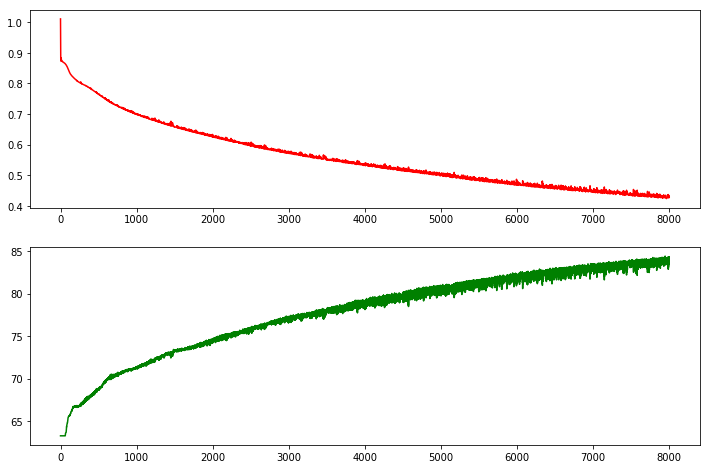

In [55]:
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
ax1.plot(print_loss, color="red")
ax2.plot(print_accuracy, color="green")
plt.show()



In [56]:
len(ts_test)

2474

overall predicted = [393 342 425]
    same     |    above    |    below
[0.889048   0.10597496 0.00497703]
Predicted (0-same, 1-above, 2-below) = 0
Labels = [0. 0. 1.]


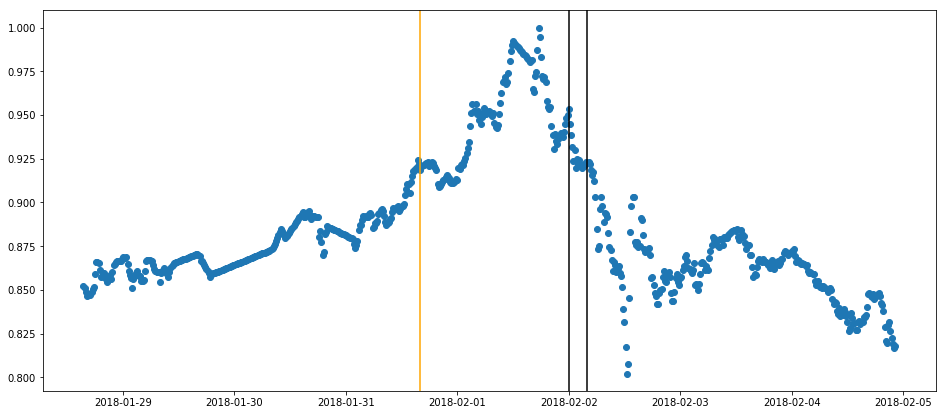

In [63]:

limit = 700#len(ts_test)

point = 290

position_on_plot = point + win_size
end_of_future_position = point + win_size + forward_time_points
start_of_train_position = point + win_size - win_size

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,7))
ax1.plot(ts_test.head(limit), 'o')
ax1.axvline(ts_test.index[position_on_plot], color='black')
ax1.axvline(ts_test.index[end_of_future_position], color='black')
ax1.axvline(ts_test.index[start_of_train_position], color='orange')



ax1.plot()

print("overall predicted = " + str((np.argmax(y_predicted,axis=0))))

print("    same     |    above    |    below")
print(y_predicted[point,:])
print("Predicted (0-same, 1-above, 2-below) = " + str(np.argmax(y_predicted[point,:],axis=0)))
print("Labels = " + str(Y_test[point,:]))
plt.show()

In [58]:
# Labels
np.argmax(Y_test[185:300,:],axis=1)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0])

In [59]:
# Predicted
np.argmax(y_predicted[185:300,:],axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])